In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.decomposition import PCA
import random

In [2]:
from keras import backend as k
from keras.utils import plot_model 
from keras.datasets import cifar10
from tensorflow.keras import layers

In [3]:
#importing dataset
(X_train,Y_train),(X_test,Y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 11s 0us/step


# Model Training

In [4]:
#Standardise the data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train/=255 
X_test/=255

latent_dim=25
img_size = 32
num_channels = 3 #32 x 32 x 3

In [5]:

#performs random sampling on the nodes
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))#the reparameterization trick!!Allows us to learn mean and variance
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [6]:
#Model
#encoder
input_img = tf.keras.layers.Input(shape=(32,32,3),name="encoder_input")

conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(input_img)
conv1 = tf.keras.layers.Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)

pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = tf.keras.layers.Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)

pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = tf.keras.layers.Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)

pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = tf.keras.layers.Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

flat = tf.keras.backend.int_shape(pool4)[1:]                  

z_mean = tf.keras.layers.Dense(latent_dim,kernel_initializer='he_normal')(tf.keras.layers.Flatten()(pool4))#mean
z_log_var = tf.keras.layers.Dense(latent_dim,kernel_initializer='he_normal')(tf.keras.layers.Flatten()(pool4))#variaince

z =Sampling()([z_mean,z_log_var])

encoder = tf.keras.models.Model(input_img,[z_mean,z_log_var,z])

In [7]:
encoder.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 32)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [8]:
#decoder
decoder_input = tf.keras.layers.Input(shape=(latent_dim,), name="decoder_input")
decoder_flat = tf.keras.layers.Dense(2*2*256,name = "decoder_flat")(decoder_input)
decoder_reshape = tf.keras.layers.Reshape(target_shape=(2,2,256))(decoder_flat)
decode_1 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=(3,3), strides=2, activation='relu', padding='same')(decoder_reshape)
decode_2 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=(3,3), strides=2, activation='relu', padding='same')(decode_1)
decode_3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3), strides=2, activation='relu', padding='same')(decode_2)
decode_4 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=2, activation='relu', padding='same')(decode_3)
decoder_output = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(1,1), strides=1, activation='sigmoid', padding='same')(decode_4)
decoder = tf.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
decoder.summary()

Model: "decoder_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 25)]              0         
_________________________________________________________________
decoder_flat (Dense)         (None, 1024)              26624     
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 256)         590080    
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 64)        73792     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 32)      

In [9]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:#using GradientTape to define custom loss function
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                keras.losses.MSE(data, reconstruction)#the reconstruction loss
            )
            reconstruction_loss *= 32 * 32
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)#KL divergence
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss # Total loss =  MSE(reconstruction) + KL diveregence(how similar the distributions are) 
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [10]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(X_train, epochs=100, batch_size=128)

Epoch 1/100
391/391 [==============================] - 26s 66ms/step - loss: 35.3729 - reconstruction_loss: 34.1355 - kl_loss: 1.2373
Epoch 2/100
391/391 [==============================] - 25s 65ms/step - loss: 19.5075 - reconstruction_loss: 17.7715 - kl_loss: 1.7360
Epoch 3/100
391/391 [==============================] - 25s 65ms/step - loss: 17.6822 - reconstruction_loss: 15.8175 - kl_loss: 1.8647
Epoch 4/100
391/391 [==============================] - 25s 65ms/step - loss: 16.9501 - reconstruction_loss: 14.9898 - kl_loss: 1.9603
Epoch 5/100
391/391 [==============================] - 25s 64ms/step - loss: 16.5606 - reconstruction_loss: 14.5724 - kl_loss: 1.9882
Epoch 6/100
391/391 [==============================] - 25s 64ms/step - loss: 16.4137 - reconstruction_loss: 14.4282 - kl_loss: 1.9855
Epoch 7/100
391/391 [==============================] - 25s 64ms/step - loss: 16.2969 - reconstruction_loss: 14.3111 - kl_loss: 1.9859
Epoch 8/100
391/391 [==============================] - 25s 64m

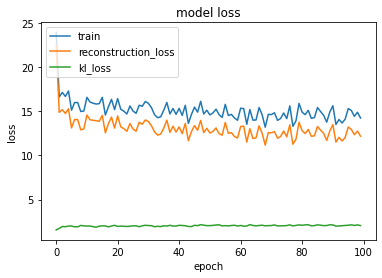

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['reconstruction_loss'])
plt.plot(history.history['kl_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'reconstruction_loss',"kl_loss"], loc='upper left')
plt.show()

# Image Clustering

In [27]:
pred1=encoder.predict(X_test)
pred1=np.array(pred1)
pred1=np.delete(pred1,2,axis=0)
pred1.shape

(2, 10000, 25)

In [28]:
pred=pred1
pred.resize(10000,50)

In [35]:
#an attempt to reduce the dimensions so that k-means clustering can work better
pca = PCA(n_components=6)
principalComponents = pca.fit_transform(pred)

In [36]:
#K-means
clustered_images = KMeans(n_clusters=10,init='k-means++',max_iter=1000).fit_predict(principalComponents)

In [37]:
for cluster in range(10):
    print('cluster: ', cluster)
    a = np.array(Y_test[np.where(clustered_images == cluster)])
    print(np.bincount(a[:,0]))
    print("Probable cluster label : ",np.argmax(np.bincount(a[:,0])))

cluster:  0
[129 123 115 129 144 111 115 108 137 127]
Probable cluster label :  4
cluster:  1
[119 117 103 133 106 124 135 122 129 128]
Probable cluster label :  6
cluster:  2
[124 111 130 117 106 131 131 130 121 127]
Probable cluster label :  5
cluster:  3
[64 72 70 64 75 65 64 68 72 68]
Probable cluster label :  4
cluster:  4
[103 142 128 130 137 133 140 125 133 140]
Probable cluster label :  1
cluster:  5
[78 85 82 62 77 85 89 74 84 87]
Probable cluster label :  6
cluster:  6
[85 63 72 84 67 77 71 76 65 65]
Probable cluster label :  0
cluster:  7
[84 81 75 89 84 79 74 82 73 71]
Probable cluster label :  3
cluster:  8
[82 77 86 71 84 82 76 83 73 68]
Probable cluster label :  2
cluster:  9
[132 129 139 121 120 113 105 132 113 119]
Probable cluster label :  2


In [38]:
copy=clustered_images

Class  0


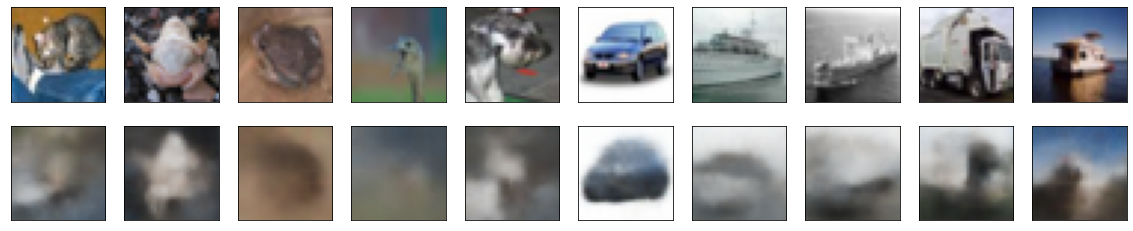

Class  1


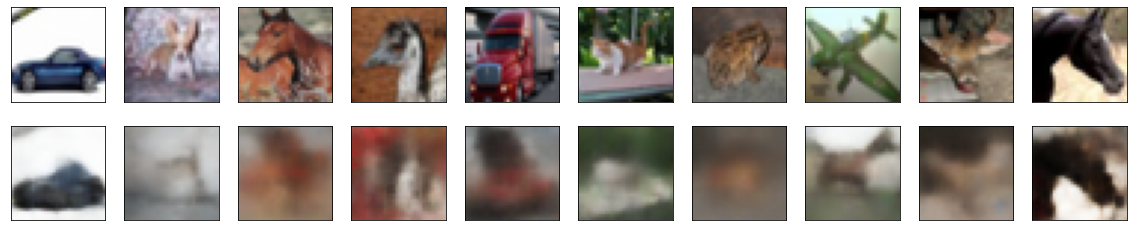

Class  2


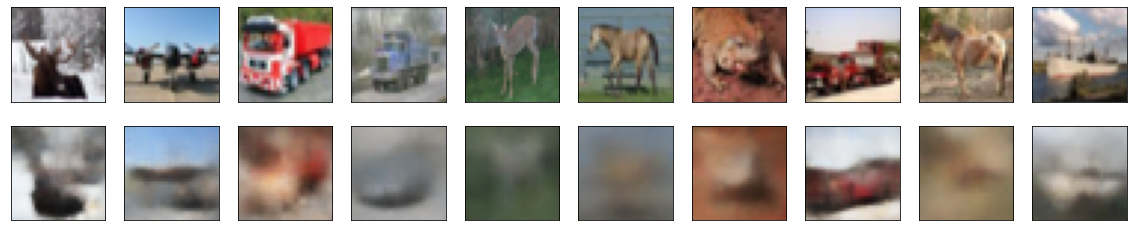

Class  3


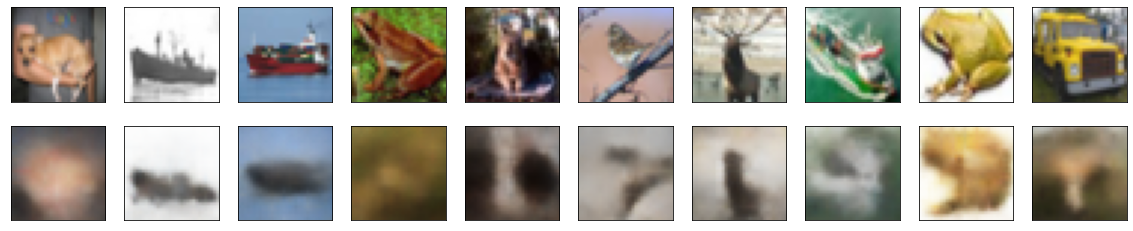

Class  4


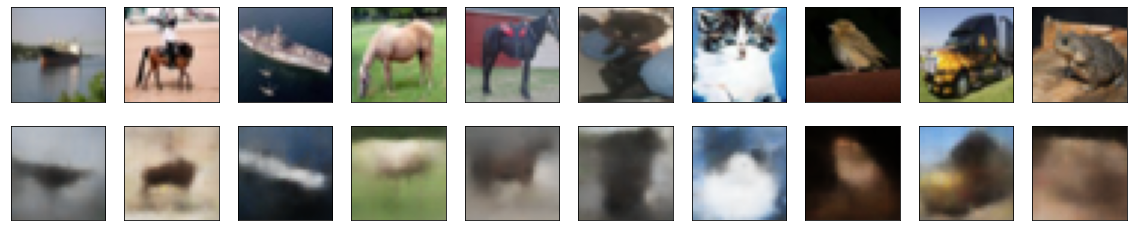

Class  5


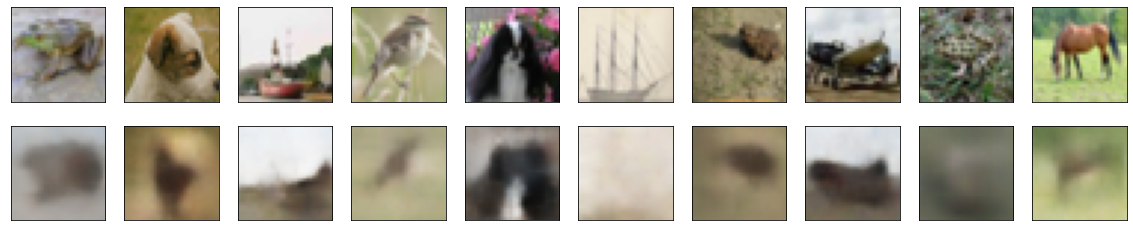

Class  6


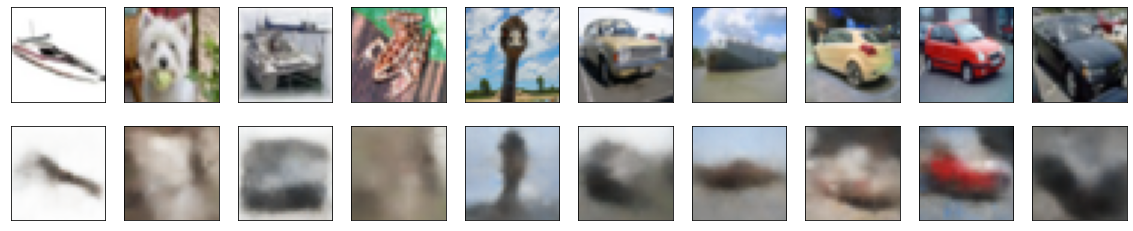

Class  7


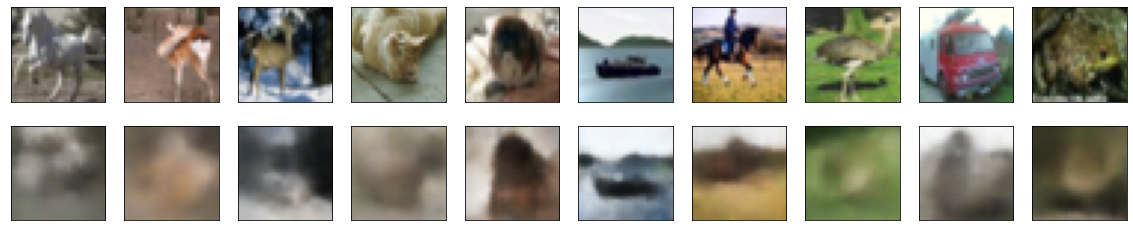

Class  8


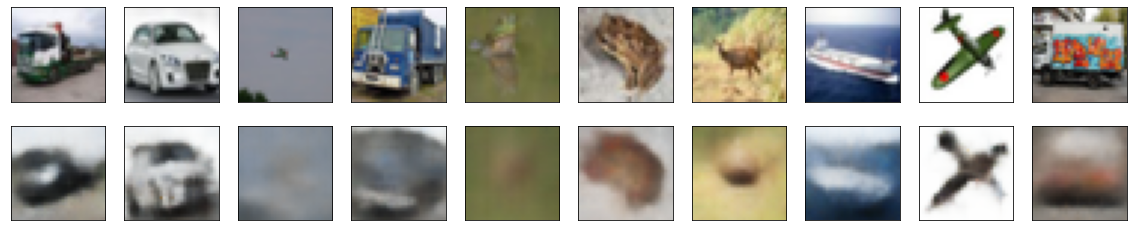

Class  9


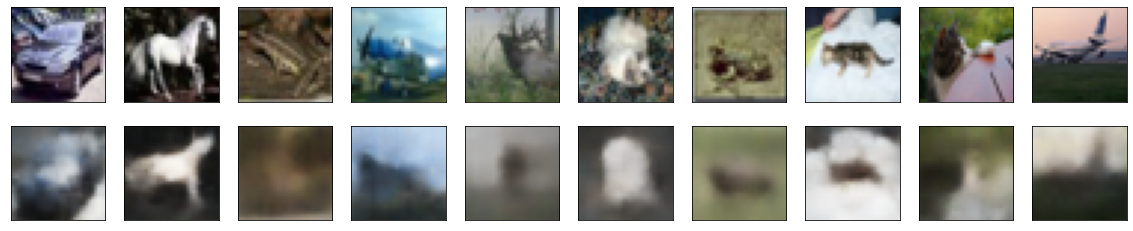

In [40]:
for i in range(10):
    n = 10
    count = 0 
    print("Class ",i)
    indices = np.array(np.where(copy==i))
    plt.figure(figsize=(20, 4))
    for j in range(n):
      # display original
        pos = random.randint(0,np.size(indices))
        ax = plt.subplot(2, n,j + 1)
        plt.imshow(X_test[pos].reshape(32,32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

      # display reconstruction
        ax = plt.subplot(2, n, j + 1 + n)
        plt.imshow(decoded_imgs2[pos].reshape(32,32,3))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        count+=1
    plt.show()

The results of K-means is not really satisfactory. The images are more or less evenly distributed with no real majority in the cluster(>50% of the cluster size).There are a few classes that have not been represented.Perhaps using a more robust clustering algorithm for images might be needed.There is a major scope for improvement.